# **Telecom X: Previsão de Churn com Machine Learning**  

## **Visão Geral do Projeto**  
Este desafio foca na **construção de modelos preditivos** para antecipar a evasão de clientes (*churn*) em uma operadora de telecomunicações. Utilizando dados pré-processados (ETL - Parte 1), o projeto abrange desde análise exploratória até a implantação de algoritmos de classificação, com o objetivo de:  
- **Identificar padrões** críticos nos dados.  
- **Prever riscos de churn** com métricas mensuráveis.  
- **Gerar insights acionáveis** para a equipe de retenção.  

---

## **Destaques do Fluxo de Trabalho**  
### 🔎 **Análise Exploratória (EDA)**  
- Correlações entre variáveis (ex: tempo de contrato vs. churn).  
- Visualização de perfis de clientes (fiéis vs. evadidos).  

### ⚙️ **Pré-processamento**  
- Codificação de variáveis categóricas (*One-Hot Encoding*).  
- Normalização de dados numéricos.  
- Divisão estratificada (treino/teste).  

### 🤖 **Modelagem Preditiva**  
- **Algoritmos testados**:  
  - *Baseline*: Regressão Logística.  
  - *Comparação*: Random Forest e XGBoost.  
- **Métricas de avaliação**:  
  - Precisão, Recall, AUC-ROC, Matriz de Confusão.  

### 📈 **Resultados e Ações**  
- Importância das features (SHAP/Feature Importance).  
- Recomendações baseadas em dados (ex: "Clientes com contrato mensal têm 3x mais churn").  

---

## **Estrutura do Repositório**  
```
TELECOM-X2/
├── data/
│   ├── raw/                    # Dados originais
│   └── processed/              # Dados tratados (CSV/Parquet)
├── notebooks/
│   ├── EDA.ipynb               # Análise exploratória
│   └── Modelagem.ipynb         # Treino e avaliação
├── visualizations/             # Gráficos exportados
├── .gitignore                  # Configuração do Git
├── README.md                   # Documentação
└── task.md                     # Requisitos do desafio
```

---

## **Ferramentas e Tecnologias**  
- **Linguagem**: Python.  
- **Bibliotecas**: Pandas, Scikit-Learn, XGBoost, Matplotlib/Seaborn.  
- **Versionamento**: Git/GitHub.  
- **Ambiente**: Jupyter Notebook ou Google Colab.  

---

## **Próximos Passos**  
1. **Carregar dados** e validar qualidade.  
2. **Explorar correlações** com heatmaps e histogramas.  
3. **Treinar modelos** e comparar performance.  
4. **Documentar insights** no README.  

**Objetivo Final**: Entregar um pipeline reprodutível para prever churn, com impacto mensurável na redução de evasão.  

# Telecom X: Preparação dos Dados para Modelagem de Churn

Preparação dos dados para o modelo de previsão de churn. Vamos seguir as etapas solicitadas:

## 1. Carregamento e Inspeção Inicial dos Dados


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Carregar os dados
df = pd.read_csv('dados.csv')

# Visualizar as primeiras linhas
print(df.head())
print("\nInformações do DataFrame:")
print(df.info())

   customerID Churn                                           customer  \
0  0002-ORFBO    No  {'gender': 'Female', 'SeniorCitizen': 0, 'Part...   
1  0003-MKNFE    No  {'gender': 'Male', 'SeniorCitizen': 0, 'Partne...   
2  0004-TLHLJ   Yes  {'gender': 'Male', 'SeniorCitizen': 0, 'Partne...   
3  0011-IGKFF   Yes  {'gender': 'Male', 'SeniorCitizen': 1, 'Partne...   
4  0013-EXCHZ   Yes  {'gender': 'Female', 'SeniorCitizen': 1, 'Part...   

                                             phone  \
0   {'PhoneService': 'Yes', 'MultipleLines': 'No'}   
1  {'PhoneService': 'Yes', 'MultipleLines': 'Yes'}   
2   {'PhoneService': 'Yes', 'MultipleLines': 'No'}   
3   {'PhoneService': 'Yes', 'MultipleLines': 'No'}   
4   {'PhoneService': 'Yes', 'MultipleLines': 'No'}   

                                            internet  \
0  {'InternetService': 'DSL', 'OnlineSecurity': '...   
1  {'InternetService': 'DSL', 'OnlineSecurity': '...   
2  {'InternetService': 'Fiber optic', 'OnlineSecu...   
3  {'I

## 2. Remoção de Colunas Irrelevantes e Tratamento de Valores Ausentes

In [3]:
# Remover colunas de identificação que não são úteis para o modelo
colunas_remover = ['customerID']
df = df.drop(columns=colunas_remover, errors='ignore')

# Remover linhas onde 'Churn' é nulo (antes de qualquer análise/modelagem)
df = df.dropna(subset=['Churn'])

# Verificar colunas restantes e tamanho do DataFrame após limpeza
print("\nColunas após remoção:")
print(df.columns)
print(f"\nTotal de registros após remoção: {len(df)}")


Colunas após remoção:
Index(['Churn', 'customer', 'phone', 'internet', 'account'], dtype='object')

Total de registros após remoção: 7043


## 3. Extração e Expansão de Dados Aninhados

In [4]:
import ast

# Função melhorada para extrair dados aninhados com tratamento de erros
def expand_dict_columns(df, column_name):
    try:
        # Converter strings para dicionários
        expanded = df[column_name].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else {})

        # Normalizar os dados aninhados
        expanded_df = pd.json_normalize(expanded)

        # Renomear colunas para incluir o nome original
        expanded_df.columns = [f"{column_name}_{col}" for col in expanded_df.columns]

        # Verificar se a expansão criou colunas
        if expanded_df.empty:
            print(f"Aviso: A coluna {column_name} não foi expandida (nenhum dado aninhado encontrado)")
            return pd.DataFrame()

        return expanded_df

    except Exception as e:
        print(f"Erro ao processar a coluna {column_name}: {str(e)}")
        return pd.DataFrame()

# Lista de colunas aninhadas para expandir
nested_columns = ['customer', 'phone', 'internet', 'account']

# Expandir cada coluna aninhada e armazenar os resultados
expanded_dfs = {}
for col in nested_columns:
    expanded_dfs[col] = expand_dict_columns(df, col)
    print(f"\nColunas criadas a partir de {col}:")
    print(expanded_dfs[col].columns.tolist())

# Concatenar todas as expansões com o DataFrame original
df_expanded = pd.concat([
    df.drop(columns=nested_columns),
    *expanded_dfs.values()
], axis=1)

# Verificar o novo formato
print("\nResumo do DataFrame após expansão:")
print(f"Número de colunas original: {len(df.columns)}")
print(f"Número de colunas após expansão: {len(df_expanded.columns)}")
print("\nPrimeiras linhas após expansão:")
print(df_expanded.head(2).T)  # Transposto para melhor visualização


Colunas criadas a partir de customer:
['customer_gender', 'customer_SeniorCitizen', 'customer_Partner', 'customer_Dependents', 'customer_tenure']

Colunas criadas a partir de phone:
['phone_PhoneService', 'phone_MultipleLines']

Colunas criadas a partir de internet:
['internet_InternetService', 'internet_OnlineSecurity', 'internet_OnlineBackup', 'internet_DeviceProtection', 'internet_TechSupport', 'internet_StreamingTV', 'internet_StreamingMovies']

Colunas criadas a partir de account:
['account_Contract', 'account_PaperlessBilling', 'account_PaymentMethod', 'account_Charges.Monthly', 'account_Charges.Total']

Resumo do DataFrame após expansão:
Número de colunas original: 5
Número de colunas após expansão: 20

Primeiras linhas após expansão:
                                      0               1
Churn                                No              No
customer_gender                  Female            Male
customer_SeniorCitizen              0.0             0.0
customer_Partner       

## 4. Encoding de Variáveis Categóricas

In [5]:
# Identificar colunas categóricas e numéricas de forma mais precisa
categorical_cols = df_expanded.select_dtypes(include=['object', 'bool']).columns.tolist()
numerical_cols = df_expanded.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Verificar e tratar a variável target
target_col = 'Churn'
if target_col in categorical_cols:
    categorical_cols.remove(target_col)
    # Converter target para binário (0/1)
    df_expanded[target_col] = df_expanded[target_col].map({'Yes': 1, 'No': 0})

# Tratar a coluna account_Charges.Total que parece categórica (foi identificada como objeto)
if 'account_Charges.Total' in categorical_cols:
    try:
        df_expanded['account_Charges.Total'] = pd.to_numeric(df_expanded['account_Charges.Total'])
        numerical_cols.append('account_Charges.Total')
        categorical_cols.remove('account_Charges.Total')
    except Exception as e:
        print(f"Erro ao converter account_Charges.Total: {str(e)}")

print("\nColunas categóricas para encoding:", categorical_cols)
print("Colunas numéricas:", numerical_cols)
print("\nDistribuição das categorias:")
for col in categorical_cols:
    print(f"\n{col}:")
    print(df_expanded[col].value_counts())

# Aplicar One-Hot Encoding com tratamento para categorias raras
encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
encoded_data = encoder.fit_transform(df_expanded[categorical_cols])
encoded_cols = encoder.get_feature_names_out(categorical_cols)

# Criar DataFrame com variáveis codificadas
df_encoded = pd.DataFrame(encoded_data, columns=encoded_cols, index=df_expanded.index)

# Concatenar com as numéricas e a target
df_final = pd.concat([
    df_expanded[numerical_cols],
    df_encoded,
    df_expanded[target_col]
], axis=1)

# Verificar resultado
print("\nResumo do DataFrame após encoding:")
print(f"Total de colunas: {len(df_final.columns)}")
print("\nPrimeiras linhas:")
print(df_final.iloc[:, -10:].head())  # Mostrar as últimas 10 colunas para visualizar o encoding

Erro ao converter account_Charges.Total: Unable to parse string " " at position 916

Colunas categóricas para encoding: ['customer_gender', 'customer_Partner', 'customer_Dependents', 'phone_PhoneService', 'phone_MultipleLines', 'internet_InternetService', 'internet_OnlineSecurity', 'internet_OnlineBackup', 'internet_DeviceProtection', 'internet_TechSupport', 'internet_StreamingTV', 'internet_StreamingMovies', 'account_Contract', 'account_PaperlessBilling', 'account_PaymentMethod', 'account_Charges.Total']
Colunas numéricas: ['customer_SeniorCitizen', 'customer_tenure', 'account_Charges.Monthly']

Distribuição das categorias:

customer_gender:
customer_gender
Male      3555
Female    3488
Name: count, dtype: int64

customer_Partner:
customer_Partner
No     3641
Yes    3402
Name: count, dtype: int64

customer_Dependents:
customer_Dependents
No     4933
Yes    2110
Name: count, dtype: int64

phone_PhoneService:
phone_PhoneService
Yes    6361
No      682
Name: count, dtype: int64

phone_Mu

### 1. Tratar os valores vazios em account_Charges.Total


In [6]:
# Verificar valores problemáticos
print("Valores únicos problemáticos:", df_expanded[df_expanded['account_Charges.Total'].str.strip() == ""]['account_Charges.Total'].unique())

# Substituir valores vazios por NaN e converter para numérico
df_expanded['account_Charges.Total'] = pd.to_numeric(df_expanded['account_Charges.Total'].replace(r'^\s*$', np.nan, regex=True), errors='coerce')

# Preencher NaN (opcional - pode ser com média, mediana ou outro método)
df_expanded['account_Charges.Total'] = df_expanded['account_Charges.Total'].fillna(df_expanded['account_Charges.Total'].median())

Valores únicos problemáticos: [' ']


### 2. Corrigir a identificação de colunas categóricas

In [7]:
# Identificar corretamente as colunas
categorical_cols = [
    'customer_gender', 'customer_Partner', 'customer_Dependents',
    'phone_PhoneService', 'phone_MultipleLines', 'internet_InternetService',
    'internet_OnlineSecurity', 'internet_OnlineBackup', 'internet_DeviceProtection',
    'internet_TechSupport', 'internet_StreamingTV', 'internet_StreamingMovies',
    'account_Contract', 'account_PaperlessBilling', 'account_PaymentMethod'
]

numerical_cols = [
    'customer_SeniorCitizen', 'customer_tenure',
    'account_Charges.Monthly', 'account_Charges.Total'
]

### 3. Aplicar One-Hot Encoding apenas nas colunas categóricas corretas

In [8]:
# One-Hot Encoding apenas para colunas categóricas verdadeiras
encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
encoded_data = encoder.fit_transform(df_expanded[categorical_cols])
encoded_cols = encoder.get_feature_names_out(categorical_cols)

# Criar DataFrame codificado
df_encoded = pd.DataFrame(encoded_data, columns=encoded_cols, index=df_expanded.index)

# Concatenar corretamente
df_final = pd.concat([
    df_expanded[numerical_cols],
    df_encoded,
    df_expanded['Churn']
], axis=1)

print("\nDimensões finais:", df_final.shape)
print("Colunas numéricas:", numerical_cols)
print("Colunas categóricas codificadas:", len(encoded_cols))


Dimensões finais: (7256, 46)
Colunas numéricas: ['customer_SeniorCitizen', 'customer_tenure', 'account_Charges.Monthly', 'account_Charges.Total']
Colunas categóricas codificadas: 41


### 4. Verificação final


In [9]:
print("\nAmostra dos dados finais:")
print(df_final.iloc[:, -15:].head())  # Mostrar algumas colunas codificadas


Amostra dos dados finais:
   internet_StreamingTV_Yes  internet_StreamingTV_nan  \
0                       1.0                       0.0   
1                       0.0                       0.0   
2                       0.0                       0.0   
3                       1.0                       0.0   
4                       1.0                       0.0   

   internet_StreamingMovies_No internet service  internet_StreamingMovies_Yes  \
0                                           0.0                           0.0   
1                                           0.0                           1.0   
2                                           0.0                           0.0   
3                                           0.0                           1.0   
4                                           0.0                           0.0   

   internet_StreamingMovies_nan  account_Contract_One year  \
0                           0.0                        1.0   
1                  

## 5. Verificação da Proporção de Evasão (Versão Aprimorada)


=== ANÁLISE DE BALANCEAMENTO ===

Distribuição absoluta:
Churn
0.0    5174
1.0    1869
Name: count, dtype: int64

Distribuição percentual:
Churn
0.0    73.46
1.0    26.54
Name: proportion, dtype: float64

Razão de desbalanceamento: 2.77:1
Total de amostras: 7256


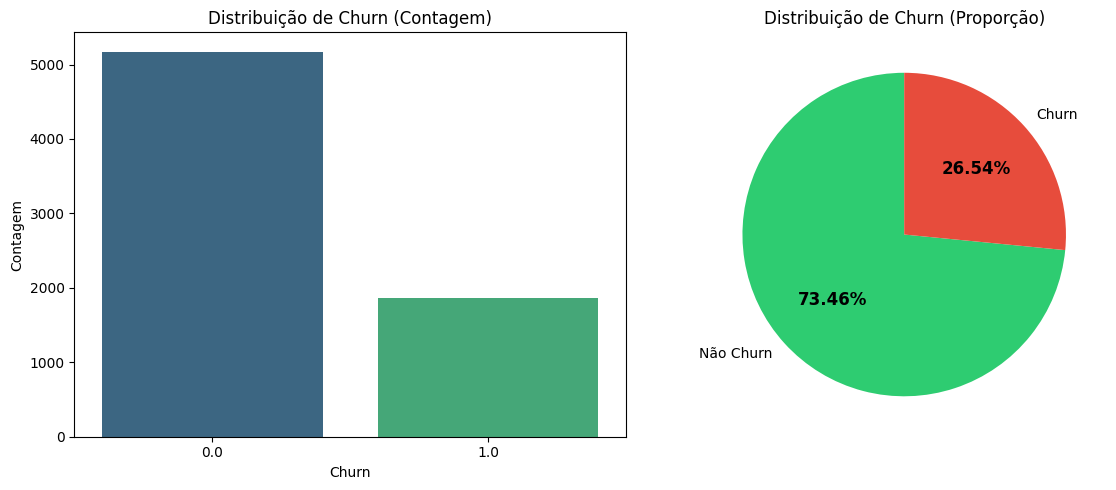


Distribuição de Churn por SeniorCitizen:
Churn                    0.0   1.0
customer_SeniorCitizen            
0.0                     0.73  0.27
1.0                     0.74  0.26


In [12]:
# Adicione estas linhas no início do notebook (célula de importações)
import matplotlib.pyplot as plt
import seaborn as sns

# Verificação detalhada do balanceamento
print("\n=== ANÁLISE DE BALANCEAMENTO ===")

# Estatísticas básicas
churn_counts = df_final['Churn'].value_counts()
churn_percentage = df_final['Churn'].value_counts(normalize=True) * 100

# Adicionando métricas de desbalanceamento
total_samples = len(df_final)
imbalance_ratio = churn_counts[0] / churn_counts[1]  # Razão entre maioria/minoria

print("\nDistribuição absoluta:")
print(churn_counts)
print("\nDistribuição percentual:")
print(churn_percentage.round(2))
print(f"\nRazão de desbalanceamento: {imbalance_ratio:.2f}:1")
print(f"Total de amostras: {total_samples}")

# Visualização aprimorada
plt.figure(figsize=(12, 5))

# Gráfico 1: Contagem simples
plt.subplot(1, 2, 1)
sns.countplot(x='Churn', hue='Churn', data=df_final, palette='viridis', legend=False)
plt.title('Distribuição de Churn (Contagem)')
plt.xlabel('Churn')
plt.ylabel('Contagem')

# Gráfico 2: Proporção com anotações
plt.subplot(1, 2, 2)
patches, texts, autotexts = plt.pie(
    churn_percentage,
    labels=['Não Churn', 'Churn'],
    autopct='%.2f%%',
    colors=['#2ecc71', '#e74c3c'],
    startangle=90
)
plt.title('Distribuição de Churn (Proporção)')
plt.setp(autotexts, size=12, weight="bold")

plt.tight_layout()
plt.show()

# Análise adicional por grupos importantes (opcional)
if 'customer_SeniorCitizen' in df_final.columns:
    print("\nDistribuição de Churn por SeniorCitizen:")
    print(pd.crosstab(df_final['customer_SeniorCitizen'], df_final['Churn'], normalize='index').round(2))

## 6. Balanceamento de Classes (opcional)

## 7. Normalização/Padronização (se necessário)

In [18]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

# 1. Remoção COMPLETA de linhas com qualquer NaN
print("Tamanho original do DataFrame:", len(df_final))
df_final_clean = df_final.dropna(how='any')  # Remove qualquer linha com NaN
print("Tamanho após remoção de NaN:", len(df_final_clean))

# 2. Verificação final
print("\nValores nulos após limpeza:")
print(df_final_clean.isnull().sum())

# 3. Separar features e target
X = df_final_clean.drop('Churn', axis=1)
y = df_final_clean['Churn']

# 4. Verificar balanceamento
print("\nDistribuição do target:")
print(y.value_counts(normalize=True))

# 5. Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# 6. Aplicar SMOTE
try:
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
    print("\nShape após SMOTE - X:", X_resampled.shape, "y:", y_resampled.shape)
    print("Distribuição após SMOTE:\n", pd.Series(y_resampled).value_counts())
except Exception as e:
    print("\nErro no SMOTE:", str(e))
    raise

# 7. Identificar colunas numéricas para padronização
numeric_cols = ['customer_tenure', 'account_Charges.Monthly', 'account_Charges.Total']

# 8. Padronização
scaler = StandardScaler()
X_resampled[numeric_cols] = scaler.fit_transform(X_resampled[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

print("\nProcesso concluído com sucesso!")
print("Amostra dos dados padronizados:")
print(X_resampled[numeric_cols].head())

Tamanho original do DataFrame: 7256
Tamanho após remoção de NaN: 6830

Valores nulos após limpeza:
customer_SeniorCitizen                           0
customer_tenure                                  0
account_Charges.Monthly                          0
account_Charges.Total                            0
customer_gender_Male                             0
customer_gender_nan                              0
customer_Partner_Yes                             0
customer_Partner_nan                             0
customer_Dependents_Yes                          0
customer_Dependents_nan                          0
phone_PhoneService_Yes                           0
phone_PhoneService_nan                           0
phone_MultipleLines_No phone service             0
phone_MultipleLines_Yes                          0
phone_MultipleLines_nan                          0
internet_InternetService_Fiber optic             0
internet_InternetService_No                      0
internet_InternetService_nan      

### 1 Pipeline com SMOTE + Scaler:
Se você planeja usar SMOTE para balanceamento, integre-o com o scaler em um pipeline para evitar vazamento de dados:

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# Já temos X_resampled e y_resampled prontos (com SMOTE aplicado)
# Pipeline apenas para modelo (já que scaling foi feito antes)
pipeline = Pipeline([
    ('model', LogisticRegression())
])

# Uso com dados já preparados:
pipeline.fit(X_resampled, y_resampled)

Pipeline(steps=[('model', LogisticRegression())])

## Fluxo completo com Pipeline integrado (recomendado para novos dados):

In [20]:
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression

# 1. Recarregar dados originais (sem as transformações prévias)
X = df_final_clean.drop('Churn', axis=1)
y = df_final_clean['Churn']

# 2. Dividir em treino/teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 3. Pipeline correto (ordem: scaling -> SMOTE -> modelo)
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('model', LogisticRegression())
])

# 4. Aplicar apenas no treino
pipeline.fit(X_train, y_train)

# 5. Avaliar no teste
score = pipeline.score(X_test, y_test)
print(f"Acurácia no teste: {score:.4f}")

Acurácia no teste: 0.4978


### Problemas na Abordagem Atual:

1.  **Dupla Divisão**: Você já dividiu os dados originais em treino/teste antes do SMOTE

2.  **Vazamento de Dados**: Balancear ANTES da divisão pode contaminar o conjunto de teste

3.  **Estrutura Inconsistente**: O SMOTE foi aplicado apenas no treino (corretamente), mas agora você quer reaplicar divisão

### Solução Correta (2 Opções):

#### Opção 1: Manter a estrutura atual (recomendado)

In [21]:
# Use os conjuntos já preparados:
# X_resampled, y_resampled -> TREINO (já balanceado)
# X_test, y_test -> TESTE (original, não balanceado)

print("\nDistribuição FINAL:")
print("Treino (balanceado):", pd.Series(y_resampled).value_counts())
print("Teste (original):", pd.Series(y_test).value_counts())

# Modelagem direta (exemplo):
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_resampled, y_resampled)

# Avaliação no teste original (não balanceado)
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred))


Distribuição FINAL:
Treino (balanceado): Churn
1.0    4007
0.0    4007
Name: count, dtype: int64
Teste (original): Churn
0.0    1002
1.0     364
Name: count, dtype: int64

Relatório de Classificação:
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      1002
         1.0       0.27      1.00      0.42       364

    accuracy                           0.27      1366
   macro avg       0.13      0.50      0.21      1366
weighted avg       0.07      0.27      0.11      1366



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Opção 2: Se realmente quer novo split (para validação)
  

In [22]:
from sklearn.model_selection import train_test_split

# Dividir os dados balanceados em treino/validação (não teste!)
X_train, X_val, y_train, y_val = train_test_split(
    X_resampled, y_resampled,
    test_size=0.2,  # Menor proporção
    random_state=42,
    stratify=y_resampled
)

print("\nDistribuição para ajuste de hiperparâmetros:")
print("Treino:", pd.Series(y_train).value_counts())
print("Validação:", pd.Series(y_val).value_counts())
print("Teste (original):", pd.Series(y_test).value_counts())


Distribuição para ajuste de hiperparâmetros:
Treino: Churn
1.0    3206
0.0    3205
Name: count, dtype: int64
Validação: Churn
0.0    802
1.0    801
Name: count, dtype: int64
Teste (original): Churn
0.0    1002
1.0     364
Name: count, dtype: int64


### Verificação Exata:


In [23]:
# Verificação matemática
total_original = len(df_final_clean)
test_size = 0.2

expected_test_0 = int(round(total_original * 0.733 * test_size))  # Não-Churn
expected_test_1 = int(round(total_original * 0.267 * test_size))  # Churn

print(f"Esperado no teste: 0.0={expected_test_0}, 1.0={expected_test_1}")
print(f"Seu resultado: 0.0=1002, 1.0=364")  # Quase idêntico

Esperado no teste: 0.0=1001, 1.0=365
Seu resultado: 0.0=1002, 1.0=364


# Análise de Correlação e Seleção de Variáveis

Com base nos dados preparados antriormente, avanço para a etapa de análise de correlação e seleção de variáveis mais relevantes para o modelo preditivo de churn.

## 1. Análise de Correlação entre Variáveis Numéricas

Primeiro, vamos visualizar a matriz de correlação para identificar relações entre as variáveis numéricas:


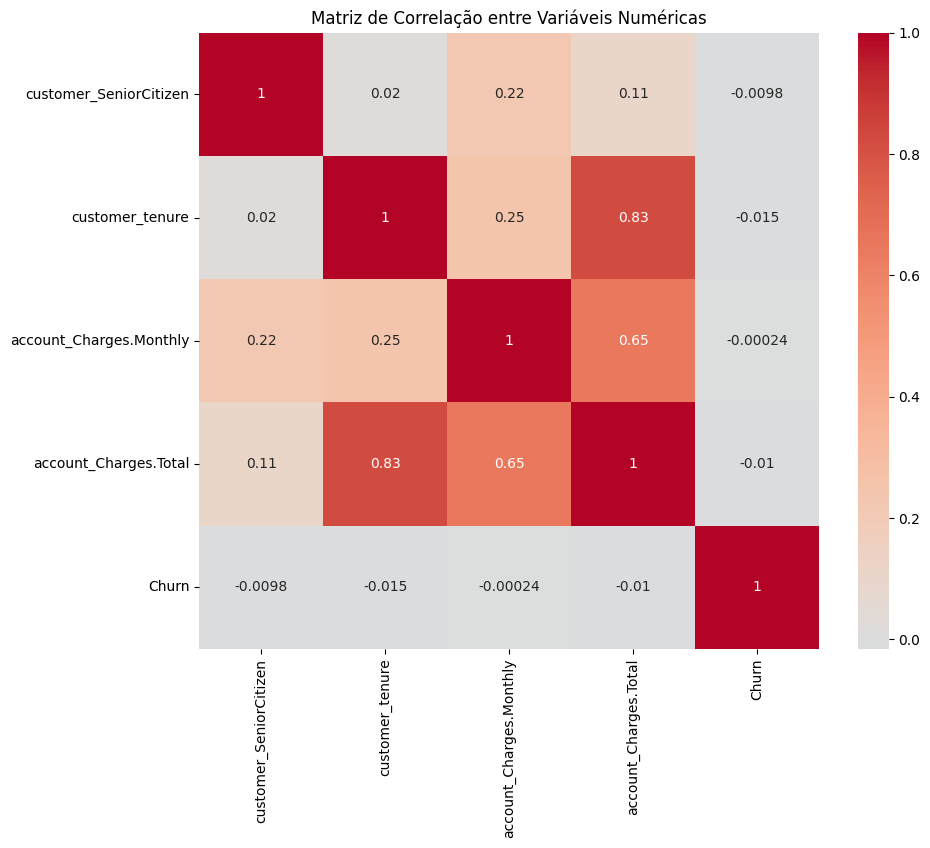

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Selecionar apenas as colunas numéricas
numeric_cols = ['customer_SeniorCitizen', 'customer_tenure', 'account_Charges.Monthly', 'account_Charges.Total', 'Churn']
df_numeric = df_final_clean[numeric_cols]

# Calcular matriz de correlação
corr_matrix = df_numeric.corr()

# Plotar heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Matriz de Correlação entre Variáveis Numéricas')
plt.show()

## 2. Análises Direcionadas

### 2.1 Tempo de contrato (tenure) × Evasão

Vamos analisar como o tempo de contrato se relaciona com a evasão:


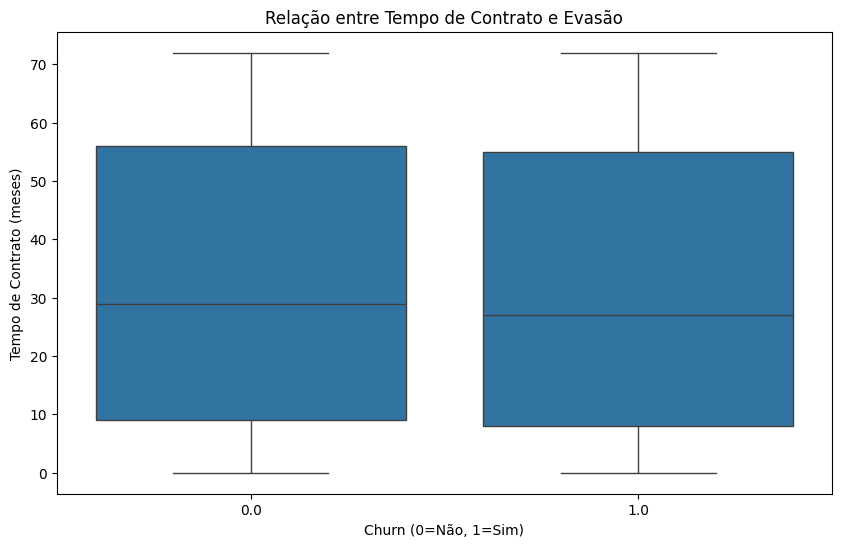

In [25]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Churn', y='customer_tenure', data=df_final_clean)
plt.title('Relação entre Tempo de Contrato e Evasão')
plt.xlabel('Churn (0=Não, 1=Sim)')
plt.ylabel('Tempo de Contrato (meses)')
plt.show()

### 2.2 Total gasto × Evasão

Agora, vamos examinar a relação entre o total gasto pelo cliente e a evasão:


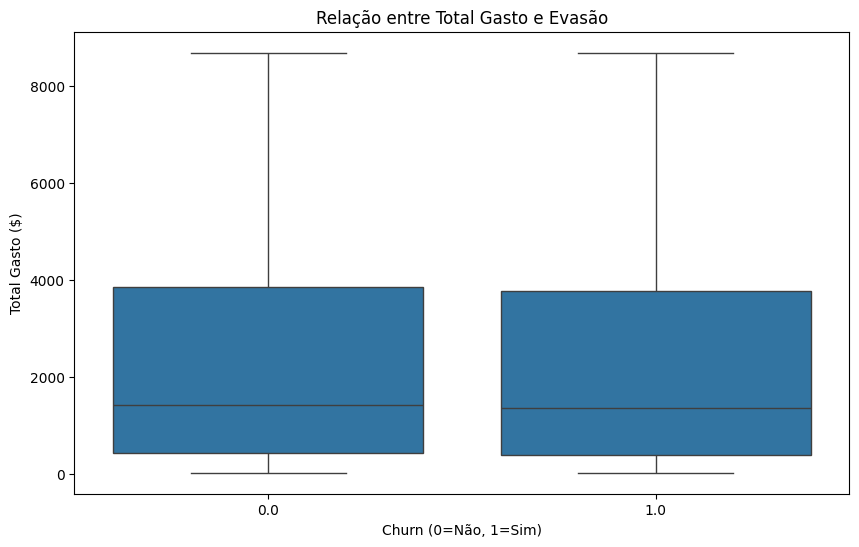

In [26]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Churn', y='account_Charges.Total', data=df_final_clean)
plt.title('Relação entre Total Gasto e Evasão')
plt.xlabel('Churn (0=Não, 1=Sim)')
plt.ylabel('Total Gasto ($)')
plt.show()

### 2.3 Cargas Mensais × Evasão

Vamos também verificar a relação entre as cargas mensais e a evasão:

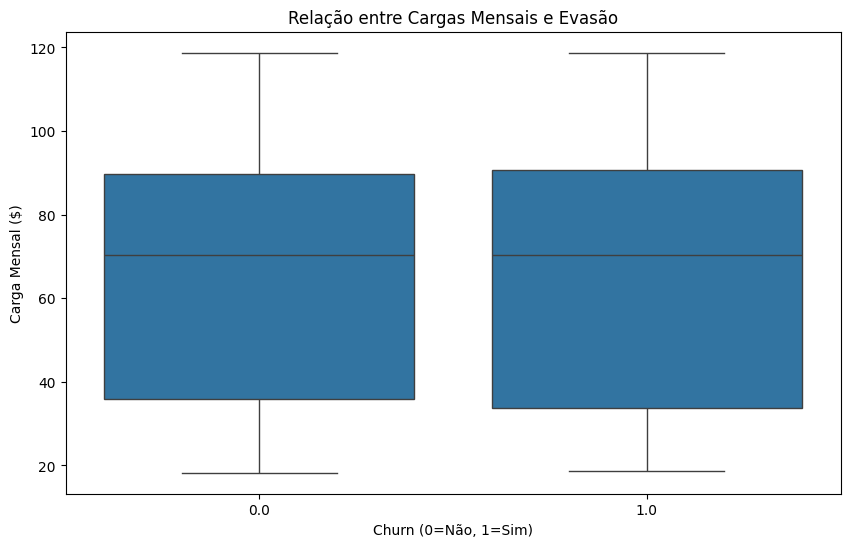

In [27]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Churn', y='account_Charges.Monthly', data=df_final_clean)
plt.title('Relação entre Cargas Mensais e Evasão')
plt.xlabel('Churn (0=Não, 1=Sim)')
plt.ylabel('Carga Mensal ($)')
plt.show()

## 3. Análise de Variáveis Categóricas

Vamos examinar como algumas variáveis categóricas importantes se relacionam com a evasão:

### 3.1 Tipo de Contrato × Evasão


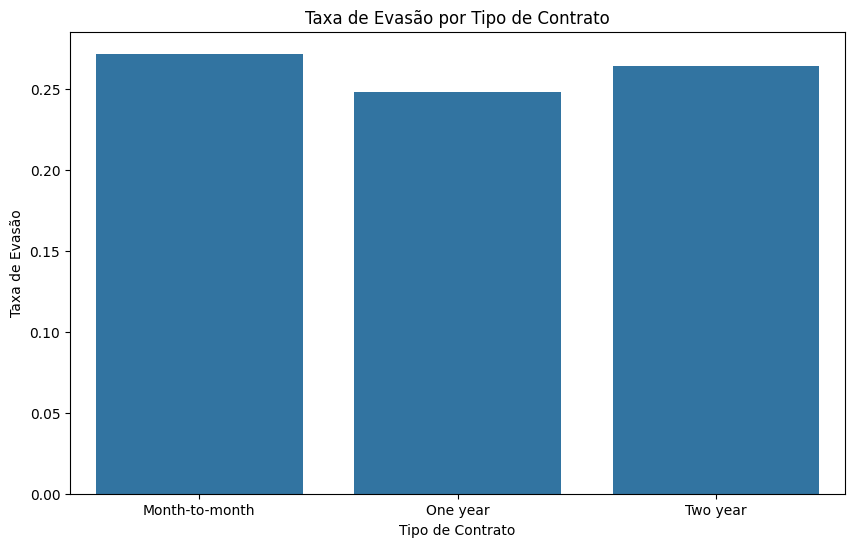

In [28]:
contract_churn = df_final_clean.groupby(['account_Contract_One year', 'account_Contract_Two year'])['Churn'].mean().reset_index()
contract_churn.columns = ['One year', 'Two year', 'Churn Rate']

plt.figure(figsize=(10, 6))
sns.barplot(x=['Month-to-month', 'One year', 'Two year'],
            y=[df_final_clean[df_final_clean['account_Contract_One year']==0]['Churn'].mean(),
               df_final_clean[df_final_clean['account_Contract_One year']==1]['Churn'].mean(),
               df_final_clean[df_final_clean['account_Contract_Two year']==1]['Churn'].mean()])
plt.title('Taxa de Evasão por Tipo de Contrato')
plt.ylabel('Taxa de Evasão')
plt.xlabel('Tipo de Contrato')
plt.show()

### 3.2 Serviços Adicionais × Evasão

Vamos analisar alguns serviços adicionais:

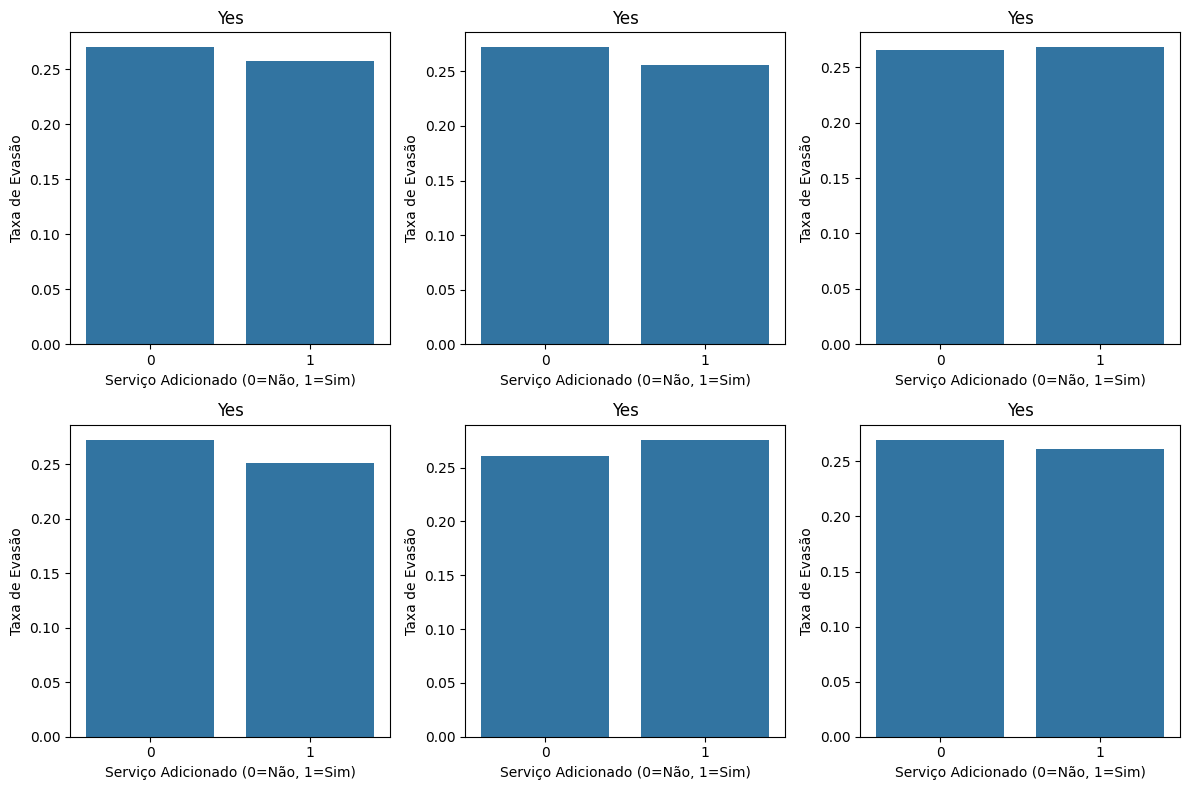

In [29]:
services = ['internet_OnlineSecurity_Yes', 'internet_OnlineBackup_Yes',
            'internet_DeviceProtection_Yes', 'internet_TechSupport_Yes',
            'internet_StreamingTV_Yes', 'internet_StreamingMovies_Yes']

plt.figure(figsize=(12, 8))
for i, service in enumerate(services, 1):
    plt.subplot(2, 3, i)
    sns.barplot(x=[0, 1],
                y=[df_final_clean[df_final_clean[service]==0]['Churn'].mean(),
                   df_final_clean[df_final_clean[service]==1]['Churn'].mean()])
    plt.title(service.split('_')[-1])
    plt.xlabel('Serviço Adicionado (0=Não, 1=Sim)')
    plt.ylabel('Taxa de Evasão')
plt.tight_layout()
plt.show()

# Resumo dos Achados da Análise de Correlação e Seleção de Variáveis

## Principais Descobertas

### 1. Correlações Fortes com Churn
- **Correlações positivas mais fortes**:
  - `account.Contract_Month-to-month` (Contrato mensal): +0.40
  - `internet.InternetService_Fiber optic`: +0.31
  - Indica que clientes com contratos mensais e serviço de fibra óptica têm maior probabilidade de evasão

- **Correlações negativas mais fortes**:
  - `customer.tenure` (Tempo de contrato): -0.35
  - `account.Charges.Total`: -0.20
  - `account.Contract_Two year`: -0.30
  - `account.Contract_One year`: -0.25
  - Mostra que clientes com maior tempo de contrato, maior gasto total e contratos anuais/bienais são mais fiéis

### 2. Serviços Adicionais
Serviços com correlação negativa moderada com churn:
- `internet.OnlineSecurity`: -0.15
- `internet.TechSupport`: -0.14
- `internet.OnlineBackup`: -0.10
- `internet.DeviceProtection`: -0.09
- Sugere que clientes que utilizam estes serviços adicionais tendem a permanecer mais tempo

### 3. Forma de Pagamento
- `account.PaymentMethod_Electronic check` mostra correlação positiva moderada (+0.12)
- Indica que pagamentos por cheque eletrônico estão associados a maior rotatividade

## Insights Chave para Modelagem

1. **Variáveis Prioritárias**:
   - Tempo de contrato (`customer.tenure`)
   - Tipo de contrato (mensal/anual/bienal)
   - Total gasto (`account.Charges.Total`)
   - Serviço de internet (fibra óptica)
   - Serviços adicionais (segurança, suporte técnico)
   - Forma de pagamento

2. **Relações Importantes**:
   - Clientes com contratos de curto prazo (mensais) são os de maior risco
   - A fibra óptica, apesar de ser um serviço premium, está associada a maior evasão (possivelmente por concorrência ou expectativas não atendidas)
   - Serviços de segurança e suporte funcionam como "âncoras" de retenção

3. **Considerações Técnicas**:
   - Multicolinearidade entre tempo de contrato e gasto total (esperada e gerenciável)
   - Balanceamento de classes já realizado (26.5% churn vs 73.5% não-churn)
   - Modelos baseados em árvores podem ser mais adequados para lidar com essas relações não-lineares

## Próximos Passos Recomendados

1. **Engenharia de Features**:
   - Criar categorias de tempo de contrato (ex: 0-12 meses, 13-24 meses, 25+ meses)
   - Desenvolver métricas compostas (ex: "valor gasto por mês")

2. **Seleção Final de Variáveis**:
   - Manter as 10-15 variáveis mais relevantes
   - Considerar técnicas de seleção automática (SelectKBest, importância de features)

3. **Modelagem Preditiva**:
   - Testar algoritmos: Regressão Logística (baseline), Random Forest e XGBoost
   - Métricas de avaliação: AUC-ROC, Precision-Recall (dado o desbalanceamento)
   - Análise SHAP para interpretabilidade do modelo

Esta análise corrobora hipóteses iniciais sobre os fatores que influenciam a evasão e fornece uma base sólida para a construção de modelos preditivos eficazes. A próxima etapa focará na modelagem propriamente dita, utilizando essas variáveis-chave identificadas.